In [3]:
import sys
import numpy as np
import matplotlib.pyplot as plt
sys.path.append(str('/home/alexandre/Documents/Projects'))

from slmOptim.patternSLM import patterns as pt
from slmOptim.optimization.init_experiment import InitExperiment
from slmOptim.optimization.iteration_algorithms import IterationAlgos

from slmOptim.optimization import cost_functions

from aotools.functions import phaseFromZernikes
import time


In [4]:
# Define observation window on camera
roi_size = 100
off = (50, -70 )

# Define camera macropixel, this is defined by the measured speckel grain
bins = 1

# Define camera acquisition parameters
exposure_time = 1
gain = 1
timeout= 100

# init.close_cam()


(104, 104)


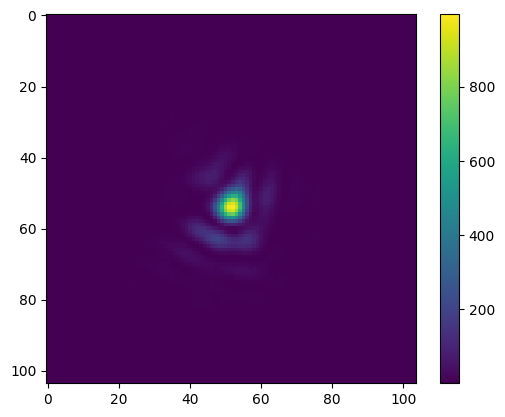

In [130]:
# init = InitExperiment(roi_size, off, bins, exposure_time, gain, timeout)
# camera = init.init_cam()
# slm = init.init_slm()

frame = camera.get_pending_frame_or_null()
frame = np.copy(frame.image_buffer)
plt.imshow(frame)
plt.colorbar()
# init.close_cam()

print(frame.shape)

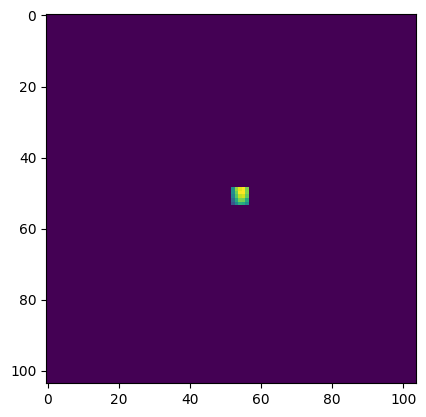

In [115]:
def masked(frame, mask_radius=3, mask_offset=(0, 0)):
    """ Thank you S. Popoff
        Creates mask with a disk in the center and calculates the ratio of the
        pixel intensity in the disk to the pixel intensity outside the disk.
    """

    res = frame.shape
    off = mask_offset
    mask_center = [res[0] // 2 + off[0], res[1] // 2 + off[1]]
    
    X, Y = np.meshgrid(np.arange(res[0]),np.arange(res[1]))

    # We generate a mask representing the disk we want to intensity to be concentrated in
    mask = (X - mask_center[0]) ** 2 + (Y - mask_center[1]) ** 2 < mask_radius ** 2

    return mask

mask = masked(frame, 3, (2, -1))
plt.imshow(frame*mask)

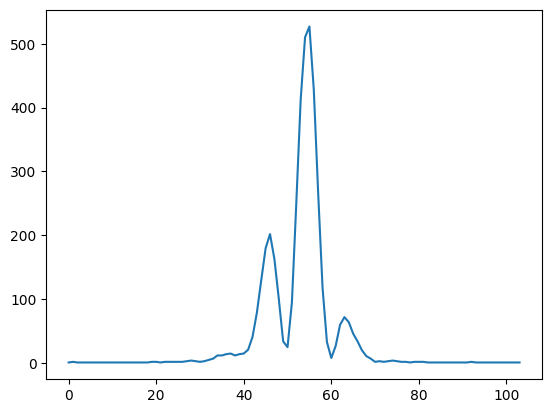

In [116]:
plt.plot(frame[51])

In [7]:
init.close_cam()
# slm = init.init_slm()

Data transmitted


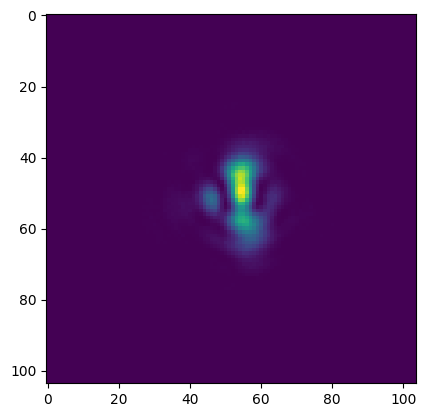

In [113]:
patSLM = pt.Pattern(800, 600)
mirror = patSLM.mirror()
slm.sendArray(mirror)

frame = camera.get_pending_frame_or_null()
frame = np.copy(frame.image_buffer)
plt.imshow(frame)

In [ ]:
slm = init.init_slm()


In [117]:
class ZernikesPolynomials():
    
    def __init__(self, 
                slm, 
                camera,
                slm_resolution=(600, 800),
                slm_calibration_pixel=112,
                num_of_zernike_coeffs=4,
                radius=300, 
                center = [600 // 2, 800 // 2],
                remote=True,
                save_path=None):
        
        self.slm = slm
        self.camera = camera
        
        # SLM
        resX, resY = slm_resolution
        self.patternSLM = pt.Pattern(resX, resY)
        self.calib_px = slm_calibration_pixel
        self.shape = slm_resolution
        
        # Zernike
        self.num_of_zernike_coeffs = num_of_zernike_coeffs
        self.radius = radius
        self.center = center
        
        # is the slm remotely connected to a rasp pi ?
        self.remote = remote
        
        # save raw data path
        # self.save_path = save_path
        # self.filepath = self._create_filepath()
    
    def register_callback(self, callback):
        """ This callback function is used to pass a custom cost function
            to the optimization object

        Parameters
        ----------
        callback
            the cost function
        """
        self.callback = callback
        
    def upload_pattern(self, pattern, slm_delay=0.1):
        """ Uploads a pattern to the SLM either in remote or local mode. Adds a user-defined
            time delay to make sure that the pattern is uploaded. 
        """
        if self.remote:
            self.slm.sendArray(pattern)
        else:
            self.slm.updateArray(pattern)
        time.sleep(slm_delay)
        
    
    def get_frame(self):
        """ Get frame from zelux thorlabs camera
        """
        frame = self.camera.get_pending_frame_or_null()
        image_buffer = np.copy(frame.image_buffer)
        return image_buffer
    
    def _get_disk_mask(self, center = None):
        '''
        Generate a binary mask with value 1 inside a disk, 0 elsewhere
        :param shape: list of integer, shape of the returned array
        :radius: integer, radius of the disk
        :center: list of integers, position of the center
        :return: numpy array, the resulting binary mask
        '''
        shape = [2 * self.radius] * 2
        if not center:
            center = (shape[0] // 2, shape[1] // 2)
        X, Y = np.meshgrid(np.arange(shape[0]), np.arange(shape[1]))
        mask = (Y - center[0]) ** 2 + (X - center[1]) ** 2 < self.radius ** 2
        return mask.astype('bool')
    
    def _complex_mask_from_zernike_coeff(self, vec):
        '''
        Generate a complex phase mask from a vector containting the coefficient of the first Zernike polynoms.
        :param DMD_resolution: list of integers, contains the resolution of the DMD, e.g. [1920,1200]
        :param: integer, radius of the illumination disk on the DMD
        :center: list of integers, contains the position of the center of the illumination disk
        :center: list of float, the coefficient of the first Zernike polynoms
        '''
        # Generate a complex phase mask from the coefficients
        zern_mask = np.exp(1j * phaseFromZernikes(vec, 2 * self.radius))
        
        # We want the amplitude to be 0 outside the disk, we fist generate a binary disk mask
        amp_mask = self._get_disk_mask()
        
        # put the Zernik mask at the right position and multiply by the disk mask
        mask = np.zeros(shape = self.shape, dtype='complex')
        mask[self.center[0] - self.radius:self.center[0] + self.radius,
             self.center[1] - self.radius:self.center[1] + self.radius] = zern_mask * amp_mask
        
        return mask
    
    def _phase2SLM(self, mask):
        arg = np.angle(mask, deg=False)
        # scale phase between 0 and 2pi
        arg2pi = (arg + 2 * np.pi) % (2 * np.pi)
        # normalize to SLM 2pi calibration value
        arg2SLM = arg2pi * 112 / (2 * np.pi) 
        return arg2SLM.astype('uint8')
        
    
    def run(self):
        
        counter = 0
        frames = {}
        cost = []
        
        coeffs = np.zeros(self.num_of_zernike_coeffs)
        phi_k = np.arange(-2, 2, 0.2)
        
        for idx in range(self.num_of_zernike_coeffs):
            cost_temp = []
            for phi in phi_k:
                coeffs[idx] = phi
                zmask = self._complex_mask_from_zernike_coeff(coeffs)
                zmask = self._phase2SLM(zmask)
                self.upload_pattern(zmask, 0.1)
                
                # get interferogram from camera
                frame = self.get_frame()

                # calculate correlation here
                cost_k = self.callback(frame)
                print(cost_k)
                cost_temp.append(cost_k)
                
            counter += 1 
            frames[counter] = frame

            # update pattern with max corr
            cost.append(np.max(cost_temp))            
            coeffs[idx] = phi_k[np.argmax(cost_temp)]

        return zmask, coeffs, cost, frames
                

In [131]:

zern = ZernikesPolynomials(slm, 
                           camera,
                           num_of_zernike_coeffs=15)
cost_fun = lambda x: cost_functions.snr(x, 1, (2, -2))
zern.register_callback(cost_fun)
mask, coeffs, cost, frames = zern.run()
slm.sendArray(mask)



Data transmitted
88.15060430073771
Data transmitted
62.15379057358827
Data transmitted
62.34364066508947
Data transmitted
64.7619179878015
Data transmitted
64.60229165278795
Data transmitted
65.93191678718433
Data transmitted
64.17290094182086
Data transmitted
68.06887678374494
Data transmitted
67.4725103329954
Data transmitted
66.91555183946488
Data transmitted
66.91961567837416
Data transmitted
65.82303249337605
Data transmitted
67.03462843456856
Data transmitted
69.68892345294968
Data transmitted
69.45578496299181
Data transmitted
68.71624548736462
Data transmitted
69.08236053460344
Data transmitted
68.22355222682894
Data transmitted
68.20487777653756
Data transmitted
68.57238538562005
Data transmitted
57.20881181157722
Data transmitted
47.45656858124032
Data transmitted
45.222208557405274
Data transmitted
48.6523637090683
Data transmitted
54.57950131146452
Data transmitted
56.701489724888596
Data transmitted
58.647078353253654
Data transmitted
59.31904308128712
Data transmitted
62.

1

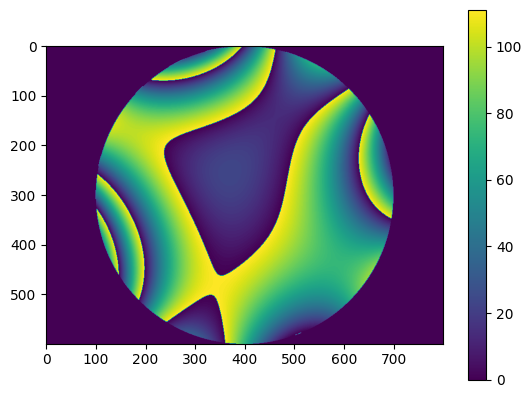

In [132]:
plt.imshow(mask)
plt.colorbar()

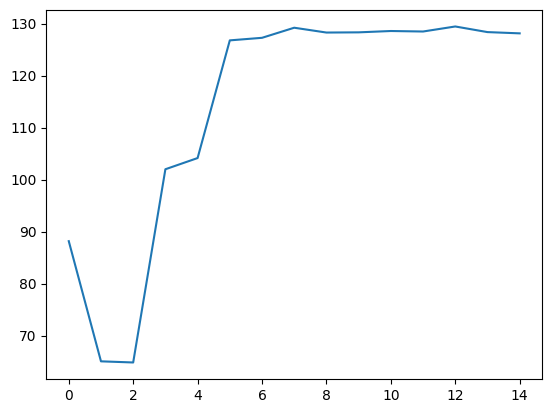

In [133]:
plt.plot(cost)


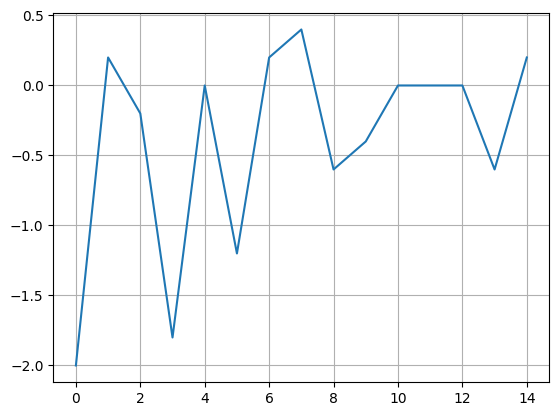

In [134]:
plt.plot((coeffs))
plt.grid()

In [122]:
coeffs

array([-2.0000000e+00, -2.0000000e+00, -2.0000000e-01,  4.0000000e-01,
        2.0000000e-01,  6.0000000e-01,  2.0000000e-01, -4.4408921e-16,
       -4.0000000e-01, -1.2000000e+00,  4.0000000e-01, -4.4408921e-16,
       -2.0000000e-01,  8.0000000e-01,  4.0000000e-01])

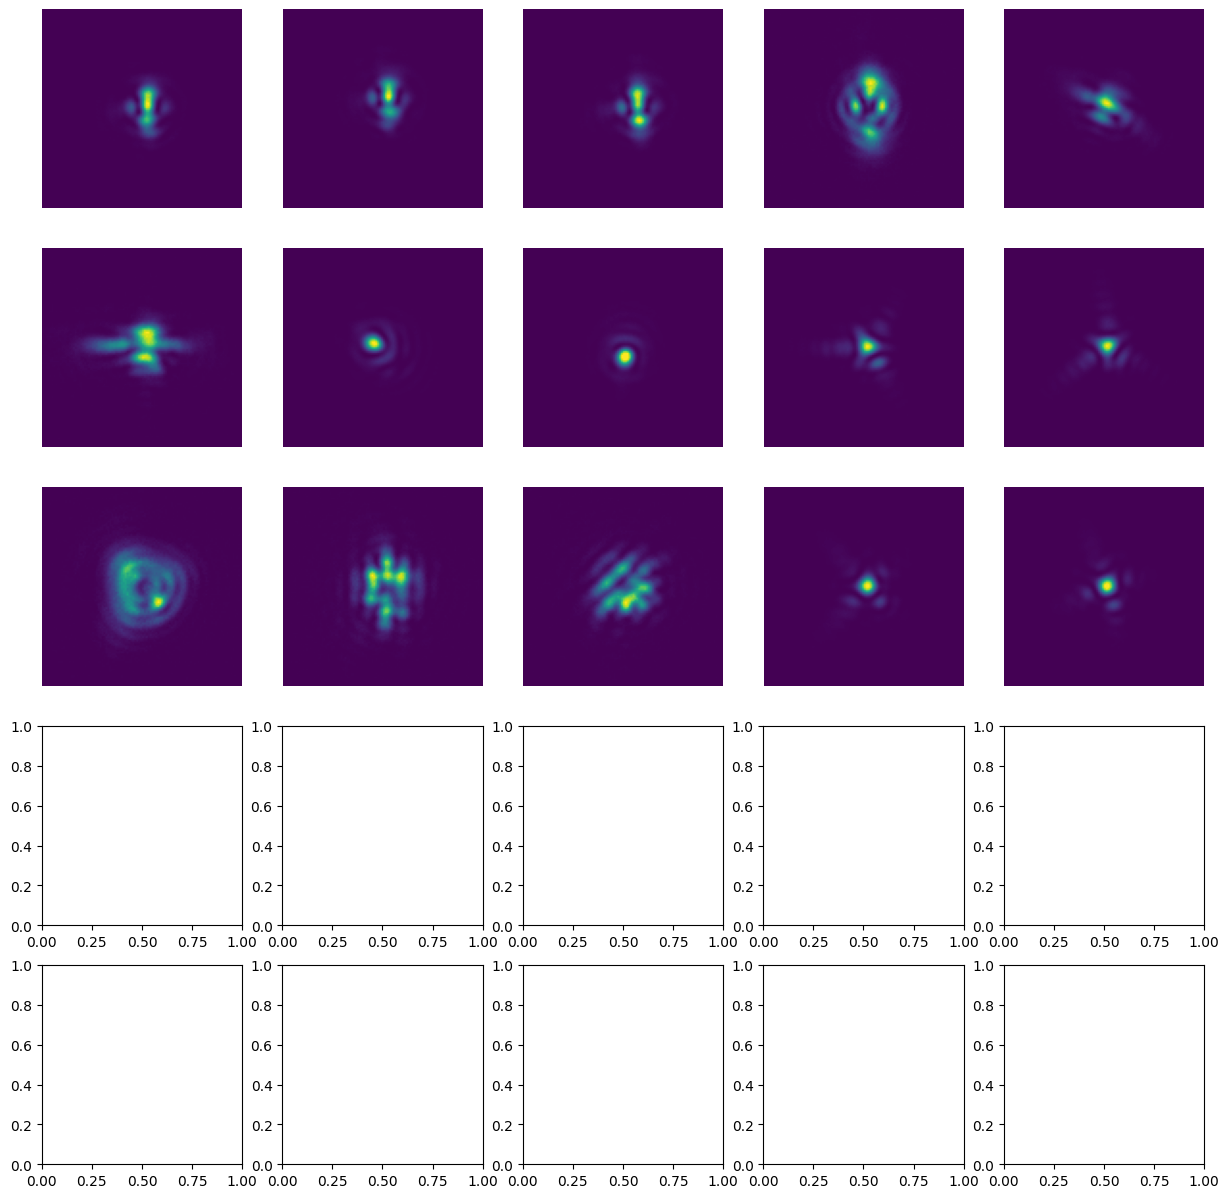

In [135]:


fig, axs = plt.subplots(nrows=5, ncols=5, figsize=(15, 15))

for matrix, ax in zip(frames.values(), axs.ravel()):
    ax.imshow(matrix)
    ax.axis('off')


In [137]:
frame = camera.get_pending_frame_or_null()
frame = np.copy(frame.image_buffer)
plt.imshow(frames[8], norm=LogNorm(vmin=1, vmax=1000))
plt.colorbar()

NameError: name 'LogNorm' is not defined

In [ ]:
shape = (600, 800)
radius = 300
vec = [1, 1, 2]
center = (shape[0]//2, shape[1]//2)


def complex_mask_from_zernike_coeff(shape, center,
                                     radius, 
                                     vec):
     '''
     Generate a complex phase mask from a vector containting the coefficient of the first Zernike polynoms.
     :param DMD_resolution: list of integers, contains the resolution of the DMD, e.g. [1920,1200]
     :param: integer, radius of the illumination disk on the DMD
     :center: list of integers, contains the position of the center of the illumination disk
     :center: list of float, the coefficient of the first Zernike polynoms
     '''
     # Generate a complex phase mask from the coefficients
     zern_mask = np.exp(1j * phaseFromZernikes(vec, 2 * radius))

     # We want the amplitude to be 0 outside the disk, we fist generate a binary disk mask
     amp_mask = get_disk_mask()

     # put the Zernik mask at the right position and multiply by the disk mask
     mask = np.zeros(shape = shape, dtype='complex')
     mask[center[0] - radius:center[0] + radius,
          center[1] - radius:center[1] + radius] = zern_mask * amp_mask

     mask = abs(mask)
     return mask.astype('uint8')

In [ ]:
test = complex_mask_from_zernike_coeff(shape, center, radius, vec)
plt.imshow(test)